# WASERSTEIN GAN WITH GRADIENT PENALTY

## PROJECT SETUP

- TensorFlow Version: 2.16.1
- Keras Version: 3.4.1
- Numpy Version: 1.26.4
- Pillow Version: 10.3.0
- Python Version: 3.11.8 | packaged by conda-forge | (main, Feb 16 2024, 20:53:32) [GCC 12.3.0]
- Matplotlib Version: 3.7.1
- Num GPUs Available: 1


### INCLUDE

In [1]:
from pathlib import Path
import os
import requests
from tqdm import tqdm
import zipfile
from tensorflow.keras import(
    utils,
    layers,
    models,
    metrics,
    optimizers,
    callbacks
)
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import logging
import concurrent.futures
import datetime
import numpy as np

2024-10-19 14:43:59.004749: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-19 14:43:59.039954: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")


Num GPUs Available: 1


2024-10-19 14:44:01.763955: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-19 14:44:01.773170: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-19 14:44:01.773198: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
#from tensorflow.keras import mixed_precision

# Установите политику смешанной точности
#mixed_precision.set_global_policy('mixed_float16')

### FUNCIONS

In [4]:
def preprocess(img):
    img=(tf.cast(img,'float32')-127.5)/127.5
    return img

def display_img(
    images,
    n=10,
    fig_size=(20,3),
    c_map='gray_r',
    as_type='float32',
    save_to=None
):
    if save_to is not None:
        oFull_path=Path(save_to)
        oPath=Path(oFull_path.parent)
        if not oPath.exists():
            oPath.mkdir
            
    if images.max() > 1.0:
        images=images/255.0
    elif images.min() < 0.0:
        images=(images+1.0)/2.0

    plt.figure(figsize=fig_size)
    for i in range(n):
        _=plt.subplot(1,n,i+1)
        plt.imshow(images[i].astype(as_type), cmap=c_map)
        plt.axis('off')

    if save_to:
        plt.savefig(save_to)


## LOAD & PREPROCESS DATA

# Initialize datasets destination folder
dataset_path=Path('./celebA/')


os.makedirs(dataset_path, exist_ok=True)

url='https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip'
output=os.path.join(dataset_path, 'img_align_celeba.zip')

# Download dataset with progress bar
response=requests.get(url,stream=True)
total_size=int(response.headers.get('content-length',0))

with open(output,'wb') as file, tqdm(
    desc=output,
    total=total_size,
    unit='B',
    unit_scale=True,
    unit_divisor=1024
) as bar:
    for data in response.iter_content(chunk_size=1024):
        bar.update(len(data))
        file.write(data)




In [5]:
def verify_single_image(img_path):
    try:
        with Image.open(img_path) as img:
            img.verify()
        return None  # No error
    except (IOError, SyntaxError) as e:
        return f"Corrupted file: {img_path} - {e}"

def verify_images(directory, log_file='corrupted_images.log', parallel=False, max_workers=4):
    """
    Verifies the integrity of image files in the specified directory.

    Args:
        directory (str): Path to the directory containing images.
        log_file (str): Path to the log file for corrupted images.
        parallel (bool): Whether to use parallel processing.
        max_workers (int): Number of threads to use for parallel processing.

    Returns:
        None
    """
    # Set up logging
    logging.basicConfig(filename=log_file, level=logging.INFO, 
                        format='%(asctime)s - %(levelname)s - %(message)s')
    
    # Supported image extensions
    valid_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')
    
    # List to hold paths of all image files
    image_files = []
    
    # Traverse the directory and collect image file paths
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(valid_extensions):
                img_path = os.path.join(root, file)
                image_files.append(img_path)
    
    # Initialize counters
    corrupted_count = 0
    corrupted_files = []
    
    if parallel:
        # Use ThreadPoolExecutor for I/O-bound operations
        with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
            # Map the verify function to image files with tqdm
            results = list(tqdm(executor.map(verify_single_image, image_files), 
                                total=len(image_files), desc="Verifying Images", unit="image"))
        
        # Process results
        for result in results:
            if result is not None:
                corrupted_count += 1
                corrupted_files.append(result)
    else:
        # Sequential processing with tqdm
        for img_path in tqdm(image_files, desc="Verifying Images", unit="image"):
            try:
                with Image.open(img_path) as img:
                    img.verify()
            except (IOError, SyntaxError) as e:
                corrupted_count += 1
                corrupted_files.append(f"Corrupted file: {img_path} - {e}")
    
    # Log corrupted files
    for corrupted_file in corrupted_files:
        logging.info(corrupted_file)
        print(corrupted_file)
    
    # Summary of verification
    total_images = len(image_files)
    print(f"\nVerification completed: {total_images} images checked.")
    if corrupted_count > 0:
        print(f"Total corrupted images found: {corrupted_count}")
        print(f"Details logged in '{log_file}'.")
    else:
        print("No corrupted images found.")

# Example usage
# Sequential verification
#verify_images('./celebA/img_align_celeba', log_file='corrupted_images.log', parallel=True, max_workers=10)

# Parallel verification (optional)
# verify_images('./celebA/img_align_celeba', log_file='corrupted_images.log', parallel=True, max_workers=8)


In [6]:
%%time
# ~6 min
# Check if 'train_data' is already initialized
if 'train_data' not in globals():
    # Load the dataset from the directory
    batch_size=256
    train_data = utils.image_dataset_from_directory(
        directory='./celebA/img_align_celeba',
        labels=None,  # Specify labels if available
        color_mode='rgb',
        image_size=(64, 64),
        batch_size=batch_size,  # Reduce if facing memory issues
        shuffle=True,
        seed=42,
        interpolation='bilinear'
    )
    
    # Define AUTOTUNE
    #AUTOTUNE = tf.data.AUTOTUNE
    
    # Optimize the dataset pipeline
    #train = train_data.cache() \
    #                  .shuffle(buffer_size=1000) \
    #                  .map(lambda x: preprocess(x), num_parallel_calls=AUTOTUNE) \
    #                  .prefetch(buffer_size=AUTOTUNE)
    train = train_data.map(lambda x: preprocess(x))

else:
    print(f"'train_data' has already been initialized, no action needed.")

Found 65596 files.


2024-10-19 14:45:38.509489: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-19 14:45:38.509544: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-19 14:45:38.509557: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-19 14:45:38.687739: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-19 14:45:38.687776: I external/local_xla/xla/stream_executor

Cause: could not parse the source code of <function <lambda> at 0x7f4caf1ccb80>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f4caf1ccb80>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 2.31 s, sys: 3.91 s, total: 6.22 s
Wall time: 1min 37s


## BUILD WGAN-GP

### CRITIC

In [7]:
critic_input=layers.Input(
    shape=(64,64,3)
)

x=layers.Conv2D(
    64,
    kernel_size=4,
    strides=2,
    padding='same'
)(critic_input)
x=layers.LeakyReLU(.2)(x)

x=layers.Conv2D(
    128,
    kernel_size=4,
    strides=2,
    padding='same'
)(x)
x=layers.LeakyReLU()(x)
x=layers.Dropout(.3)(x)

x=layers.Conv2D(
    256,
    kernel_size=4,
    strides=2,
    padding='same'
)(x)
x=layers.LeakyReLU(0.2)(x)
x=layers.Dropout(.3)(x)

x=layers.Conv2D(
    512,
    kernel_size=4,
    strides=2,
    padding='same'
)(x)
x=layers.LeakyReLU(.2)(x)
x=layers.Dropout(.3)(x)

x=layers.Conv2D(
    1,
    kernel_size=4,
    strides=1,
    padding='valid'
)(x)

critic_output=layers.Flatten()(x)

In [8]:
critic=models.Model(critic_input,critic_output)
critic.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 512)      │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 1, 1, 1)        │         8,193 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,764,737 (10.55 MB)

 Trainable params: 2,764,737 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

### GENERATOR

In [9]:
generator_input=layers.Input(shape=(128,))

x=layers.Reshape(
    (1,1,128)    
)(generator_input)

x=layers.Conv2DTranspose(
    512,
    kernel_size=4,
    strides=1,
    padding='valid',
    use_bias=False
)(x)
x=layers.BatchNormalization(momentum=.9)(x)
x=layers.LeakyReLU(.2)(x)

x=layers.Conv2DTranspose(
    256,
    kernel_size=4,
    strides=2,
    padding='same',
    use_bias=False
)(x)
x=layers.BatchNormalization(momentum=.9)(x)
x=layers.LeakyReLU(.2)(x)

x=layers.Conv2DTranspose(
    128,
    kernel_size=4,
    strides=2,
    padding='same',
    use_bias=False
)(x)
x=layers.BatchNormalization(momentum=.9)(x)
x=layers.LeakyReLU(.2)(x)

x=layers.Conv2DTranspose(
    64,
    kernel_size=4,
    strides=2,
    padding='same',
    use_bias=False
)(x)
x=layers.BatchNormalization(momentum=.9)(x)
x=layers.LeakyReLU(.2)(x)

generator_output=layers.Conv2DTranspose(
    3,
    kernel_size=4,
    strides=2,
    padding='same',
    activation='tanh'
)(x)


In [10]:
generator=models.Model(generator_input,generator_output)
generator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 4, 4, 512)      │     1,048,576 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 8, 8, 256)      │     2,097,152 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 16, 16, 128)    │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 32, 32, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 64, 64, 3)      │         3,075 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,808,003 (14.53 MB)

 Trainable params: 3,806,083 (14.52 MB)

 Non-trainable params: 1,920 (7.50 KB)

### WGANGP

In [11]:
class WGANGP(models.Model):
    def __init__(self,critic,generator,latent_dim,critic_steps,gp_weight):
        super(WGANGP,self).__init__()

        # Critic is an another name of discriminator in GAN. It's role is score real vs fake images
        self.critic=critic
        # Generator creates fake images
        self.generator=generator
        # Dimensionality of the random latent space
        self.latent_dim=latent_dim
        # Number of critic updates per generator update
        self.critic_steps=critic_steps
        # Weight for gradient penalty for regularization
        self.gp_weight=gp_weight

    def compile(self,c_optimizer,g_optimizer):
        super(WGANGP,self).compile()
        self.c_optimizer=c_optimizer
        self.g_optimizer=g_optimizer
        
        # Metrics to track the loss of critic and generator during traning
        self.c_wass_loss_metric=metrics.Mean(name='c_wass_loss') # Critic Waserstein loss
        self.c_gp_metric=metrics.Mean(name='c_gp') # Gradient penalty
        self.c_loss_metric=metrics.Mean(name='c_loss') # Combined loss of critic
        self.g_loss_metric=metrics.Mean(name='g_loss') # Generator's loss

    @property
    def metrics(self):
        return [
            self.c_loss_metric,
            self.c_wass_loss_metric,
            self.c_gp_metric,
            self.g_loss_metric
        ]

    def gradient_penalty(
        self,
        batch_size,
        real_images,
        fake_images
    ):
        # Calculates the gradient penalty(GP) used for regularization
        
        # Enforce Lischitz constraint
        # 1. Create interpolated images
        alpha=tf.random.normal([batch_size,1,1,1],.0,1.0) # Create tenzor with random and normal distributed values with μ=0.0(math expect.) and σ=1.0(standard diviation)
        diff=fake_images-real_images
        interpolated=real_images+alpha*diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred=self.critic(interpolated,training=True)

        # Computes the gradients of the critic's pedictions with respect to iterpolated images
        grads=gp_tape.gradient(pred,[interpolated])[0]
        # Compute L2(Euclidian ∣∣∇f(x)∣∣) norm of the gradient.(The magnitude of the gradients ignoring their directions)
        norm=tf.sqrt(tf.reduce_sum(tf.square(grads),axis=[1,2,3])) 
        # Gradient penalty GP=E((∣∣∇f(x)∣∣−1)^2)
        gp=tf.reduce_mean((norm-1.0)**2)

        # Return the Gradient Penalty
        return gp

    def train_step(self,real_images):
        # Get the batch size for the traning step
        batch_size=tf.shape(real_images)[0]

        # Run Critic traning loop.
        # Update the critic multiple times befoure the generator
        for i in range(self.critic_steps):
            # Generate random latent vectors for generator input
            random_latent_vectors=tf.random.normal(shape=(batch_size,self.latent_dim))

            with tf.GradientTape() as tape:
                # Generate fake images
                fake_images=self.generator(random_latent_vectors,training=True)
                # Get critic predictions on fake images
                fake_predictions=self.critic(fake_images,training=True)
                # Get critic predictions on real images
                real_predictions=self.critic(real_images,training=True)

                # Calc Waserstein loss for critic(diffirence in critic predicions)
                c_wass_loss=tf.reduce_mean(fake_predictions) - tf.reduce_mean(real_predictions)
                # Compute gradient penalty
                c_gp=self.gradient_penalty(batch_size,real_images,fake_images)
                # Total critic loss = Waserstein loss + gradient penalty
                c_loss=c_wass_loss + c_gp * self.gp_weight

            # Compute gradient for critic
            c_gradient=tape.gradient(c_loss,self.critic.trainable_variables)

            # Apply gradient to update critic's weights
            self.c_optimizer.apply_gradients(
                zip(c_gradient,self.critic.trainable_variables)
            )

        # After update critic let's update the generator
        # Generate random latent vectors for generator input
        random_latent_vectors=tf.random.normal(shape=(batch_size,self.latent_dim))

        with tf.GradientTape() as tape:
            # NOTE: The GradientTape is used to automatically track computations to later compute gradients with respect to a loss.
            #       ven though tape.watch() is not explicitly called here, TensorFlow automatically tracks trainable variables 
            #       (like weights and biases in self.critic.trainable_variables) when they are involved in differentiable operations within the GradientTape context.
            # Generate fake images
            fake_images=self.generator(random_latent_vectors,training=True)
            # Get critic's prediciotns for the fake images
            fake_predictions=self.critic(fake_images,training=True)
            # Generator loss(minimizing critic's score on fake images)
            g_loss= -tf.reduce_mean(fake_predictions)

        # Compute gradient for generator
        gen_gradient=tape.gradient(g_loss, self.generator.trainable_variables)
        # Apply the gradients to update the generator's weights
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))

        # Update metrics
        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return { m.name: m.result() for m in self.metrics }

In [12]:
wgangp=WGANGP(
    critic=critic,
    generator=generator,
    latent_dim=128,
    critic_steps=3,
    gp_weight=10.0
)

## TRAIN

In [13]:
wgangp.compile(
    c_optimizer=optimizers.Adam(learning_rate=2e-4,beta_1=.5,beta_2=.9),
    g_optimizer=optimizers.Adam(learning_rate=2e-4,beta_1=.5,beta_2=.9)
)

In [14]:
%%time
# tensorboard --logdir=/mnt/c/Users/MaksV/Documents/repo/Data-Science-Portfolio/Deep-Learning/logs
log_dir='./logs/celeba/fit/'+ datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

model_checkpoint_callback=callbacks.ModelCheckpoint(
    filepath='./checkpoint.keras',
    save_weights_only=False,
    save_freq='epoch',
    monitor='loss',
    mode='min',
    save_best_only=True,
    verbose=0
)

tensorboard_callback=callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=1
)

CPU times: user 1.1 ms, sys: 0 ns, total: 1.1 ms
Wall time: 584 μs


2024-10-19 14:45:40.217394: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-10-19 14:45:40.217427: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-10-19 14:45:40.217450: I external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1239] Profiler found 1 GPUs
2024-10-19 14:45:40.217741: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:137] cuptiGetTimestamp: error 999: 
2024-10-19 14:45:40.217749: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:186] cuptiSubscribe: ignored due to a previous error.
2024-10-19 14:45:40.217752: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:223] cuptiGetResultString: ignored due to a previous error.
2024-10-19 14:45:40.217755: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1282] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with

In [15]:
%%time
log_dir='./logs/celeba/fit/'+datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

model_checkpoint_callback=callbacks.ModelCheckpoint(
    filepath='./checkpoint.keras',
    save_weights_only=False,
    save_freq='epoch',
    monitor='loss',
    mode='min',
    save_best_only=True,
    verbose=0
)

tensorboard_callback=callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=1
)

class ImageGenerator(callbacks.Callback):
    def __init__(self,num_img,latent_dim,save_to):
        self.num_img=num_img
        self.latent_dim=latent_dim
        self.save_to=save_to

    def on_epoch_end(self,epoch,logs=None):
        random_latent_vectors=tf.random.normal(
            shape=(self.num_img,self.latent_dim)
        )
        generated_images=self.model.generator(random_latent_vectors)
        generated_images=generated_images * 127.5 + 127.5
        generated_images=generated_images.numpy()
        export_path=self.save_to + '/generated_img%03d.png' % (epoch)
        display_img(
            generated_images,
            c_map=None,
            save_to=export_path            
        )
 

CPU times: user 220 μs, sys: 140 μs, total: 360 μs
Wall time: 244 μs


2024-10-19 14:45:40.231610: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-10-19 14:45:40.231642: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-10-19 14:45:40.231677: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2024-10-19 14:45:40.231682: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:186] cuptiSubscribe: ignored due to a previous error.
2024-10-19 14:45:40.231684: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:223] cuptiGetResultString: ignored due to a previous error.
2024-10-19 14:45:40.231688: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1282] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error 
2024-10-19 14:45:40.231708: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:131]

Epoch 1/10


I0000 00:00:1729309545.720547    2924 service.cc:145] XLA service 0x7f4bec0071e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729309545.720597    2924 service.cc:153]   StreamExecutor device (0): NVIDIA T1200 Laptop GPU, Compute Capability 7.5
2024-10-19 14:45:46.114355: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-19 14:45:47.276224: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-10-19 14:46:09.390270: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.78GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
I0000 00:00:1729309594.862328    2924 device_compiler.h:188] Compiled cluster using XLA

  1/257 ━━━━━━━━━━━━━━━━━━━━ 4:01:42 57s/step - c_gp: 0.7246 - c_loss: 6.0614 - c_wass_loss: -1.1848 - g_loss: -0.9395

2024-10-19 14:46:36.915114: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-10-19 14:46:36.915158: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-10-19 14:46:36.915179: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2024-10-19 14:46:36.915185: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:186] cuptiSubscribe: ignored due to a previous error.
2024-10-19 14:46:36.915187: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:223] cuptiGetResultString: ignored due to a previous error.
2024-10-19 14:46:36.915193: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1282] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error 
2024-10-19 14:46:38.522215: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:70] 

256/257 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - c_gp: 2.0665 - c_loss: -41.5104 - c_wass_loss: -62.1756 - g_loss: -14.7545

2024-10-19 14:56:13.527607: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - c_gp: 2.0624 - c_loss: -41.4376 - c_wass_loss: -62.0615 - g_loss: -14.8170

/home/zai11972/miniconda3/envs/tensrnv/lib/python3.11/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
2024-10-19 14:56:41.793620: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.22GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


257/257 ━━━━━━━━━━━━━━━━━━━━ 662s 2s/step - c_gp: 2.0583 - c_loss: -41.3653 - c_wass_loss: -61.9483 - g_loss: -14.8790
Epoch 2/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 1225s 5s/step - c_gp: 0.2208 - c_loss: -8.6506 - c_wass_loss: -10.8582 - g_loss: -50.0817
Epoch 3/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 1226s 5s/step - c_gp: 0.1461 - c_loss: -6.4606 - c_wass_loss: -7.9217 - g_loss: -39.6836
Epoch 4/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 1226s 5s/step - c_gp: 0.1022 - c_loss: -5.2125 - c_wass_loss: -6.2342 - g_loss: -45.3957
Epoch 5/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 1225s 5s/step - c_gp: 0.0805 - c_loss: -4.4821 - c_wass_loss: -5.2869 - g_loss: -43.7607
Epoch 6/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 1225s 5s/step - c_gp: 0.0725 - c_loss: -4.1060 - c_wass_loss: -4.8313 - g_loss: -64.3350
Epoch 7/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 1227s 5s/step - c_gp: 0.0626 - c_loss: -3.8936 - c_wass_loss: -4.5194 - g_loss: -102.0837
Epoch 8/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 1226s 5s/step - c_gp: 0.0563 - c_loss: -2.6937 - c_wass_loss: -3.

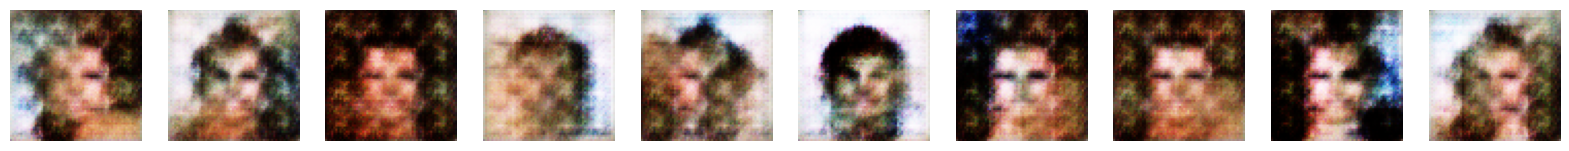

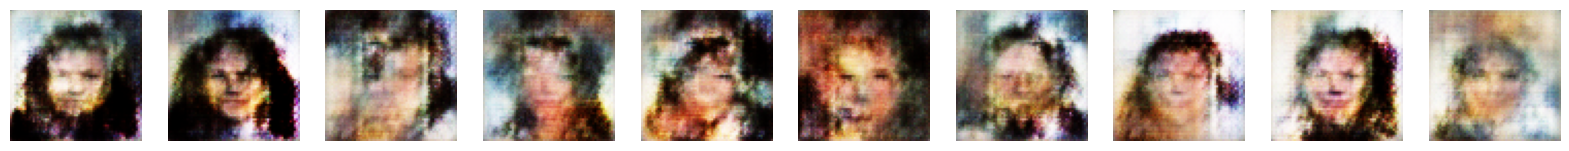

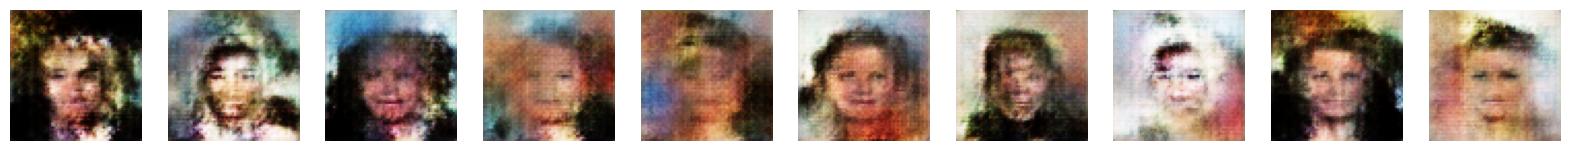

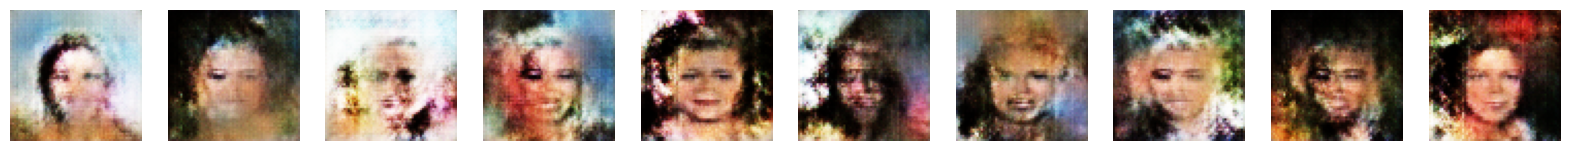

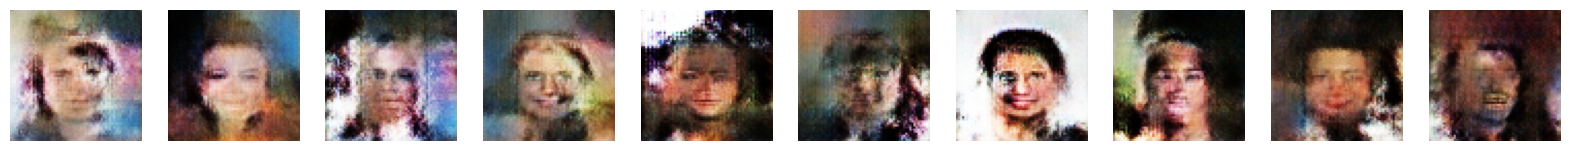

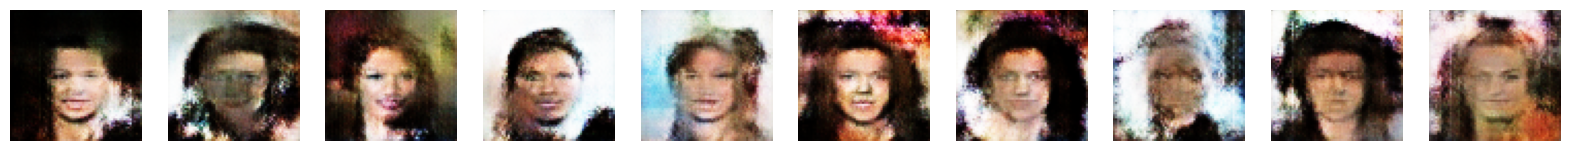

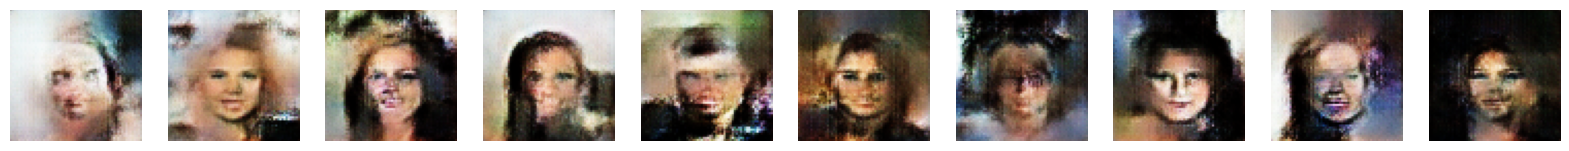

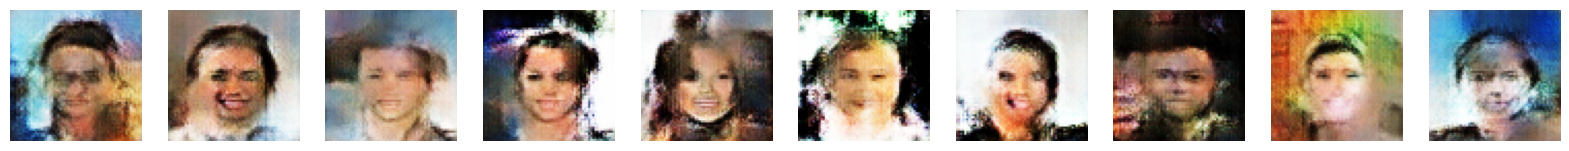

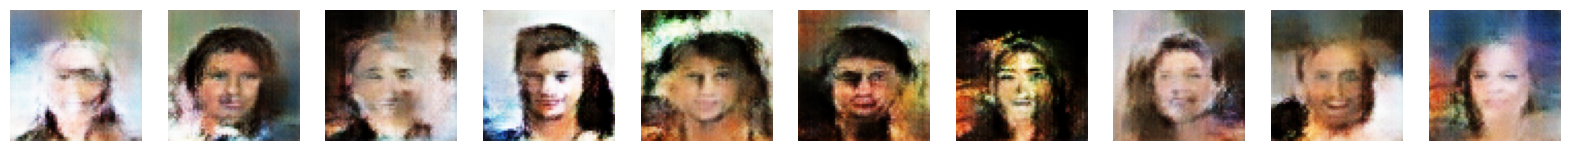

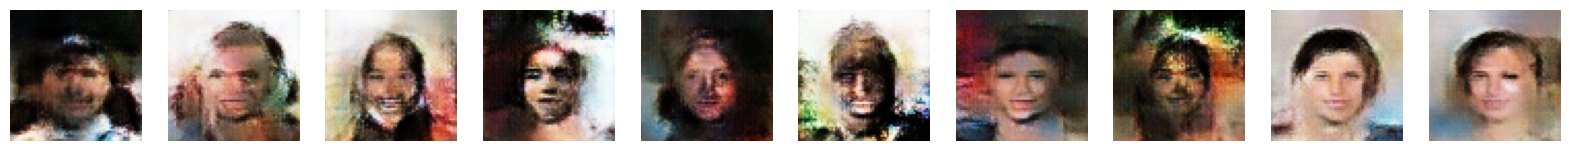

In [16]:
wgangp.fit(
    train,
    epochs=10,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(
            num_img=10,
            latent_dim=128,
            save_to=log_dir + '/images'
        )
    ]
)


In [19]:
# Save the final models
generator.save("./models/wgangp/generator.keras")
critic.save("./models/wgangp/critic.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


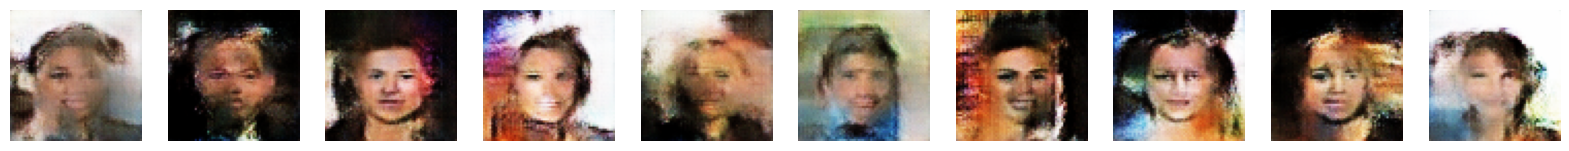

In [21]:
z_sample = np.random.normal(size=(10, 128))
imgs = wgangp.generator.predict(z_sample)
display_img(imgs, c_map=None)

**SUMMARY**

WWhat we observe here is that it took only 10 epochs of training, yet the results are far more promising than those from DCGAN or CNN. The Wasserstein algorithm, combined with the GAN architecture and gradient penalty, significantly enhanced the quality of the generated images.

An interesting fact: in the first version of my code, I missed a few lines, resulting in completely noisy images (see below).

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

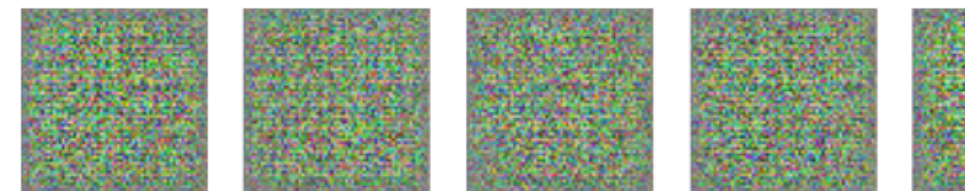

At first, I was disappointed and almost abandoned the project. However, I decided to review my code, and sure enough, I found the issues (all errors occurred in the WGANGP class):

1. There was an indentation problem in the train_step function. I moved the line c_gradient=tape.gradient(c_loss,self.critic.trainable_variables) inside the for loop, which caused the generation of random gradients without updating the generator's weights. This meant the generator wasn’t being trained, while the critic was improving at distinguishing real from fake images.

2. I completely missed the following code:
```
    # Compute gradient for generator
        gen_gradient=tape.gradient(g_loss, self.generator.trainable_variables)
        # Apply the gradients to update the generator's weights
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))
   ```
As a result, the generator's metrics (g_loss_metric) weren’t updated, and its loss function wasn’t computed in the critic loop, meaning the generator remained stuck in a random phase without learning.



**References**

1. [Generative Deep Learning, 2nd Edition](https://www.oreilly.com/library/view/generative-deep-learning/9781098134174/): David Foster's book from which has become an inspiration of this notebook.
2. [David Foster](https://github.com/davidADSP): GitHub page
3. [David Foster (Keynote) - Generative Deep Learning -Key To Unlocking Artificial General Intelligence?](https://www.youtube.com/watch?v=rHLf78CmNmQ): David's video session at Youtube regarding some key concepts has written in his book
4. [Animated AI](https://www.youtube.com/@animatedai): Youtube channel with amazing visualizations of how exactly 